# Information retrieval for movies recommendation

Database which the project it's based on:   
[HBO Max](https://www.kaggle.com/datasets/dgoenrique/hbo-max-movies-and-tv-shows)  

<div></div> 

In [1]:
import numpy as np 
import pandas as pd

from plotnine import *
from sklearn.preprocessing import StandardScaler

<div></div> 

## Files import

File created in the previous notebook, if you're having problem with the import, I recomendo you to look at the notebook 00

<div></div> 

In [2]:
dtm = pd.read_parquet('../data/enriched_data.parquet.gzip')
dtm.head(3)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,year,tm_id,overview,popularity,vote_average,vote_count
0,tm77588,Casablanca,MOVIE,"In Casablanca, Morocco in December 1941, a cyn...",1943,PG,102,"['drama', 'romance', 'war']",['US'],NaN,...,8.5,577842.0,22.005,8.167,1942-11-26,289.0,"In Casablanca, Morocco in December 1941, a cyn...",23.881,8.170,4751.0
1,tm155702,The Wizard of Oz,MOVIE,Young Dorothy finds herself in a magical world...,1939,G,102,"['fantasy', 'family']",['US'],NaN,...,8.1,406105.0,56.631,7.583,1939-08-15,630.0,Young Dorothy finds herself in a magical world...,50.652,7.578,4971.0
2,tm83648,Citizen Kane,MOVIE,"Newspaper magnate, Charles Foster Kane is take...",1941,PG,119,['drama'],['US'],NaN,...,8.3,446627.0,19.900,8.022,1941-04-17,15.0,"Newspaper magnate, Charles Foster Kane is take...",20.239,8.019,4883.0


## Data Explotarion

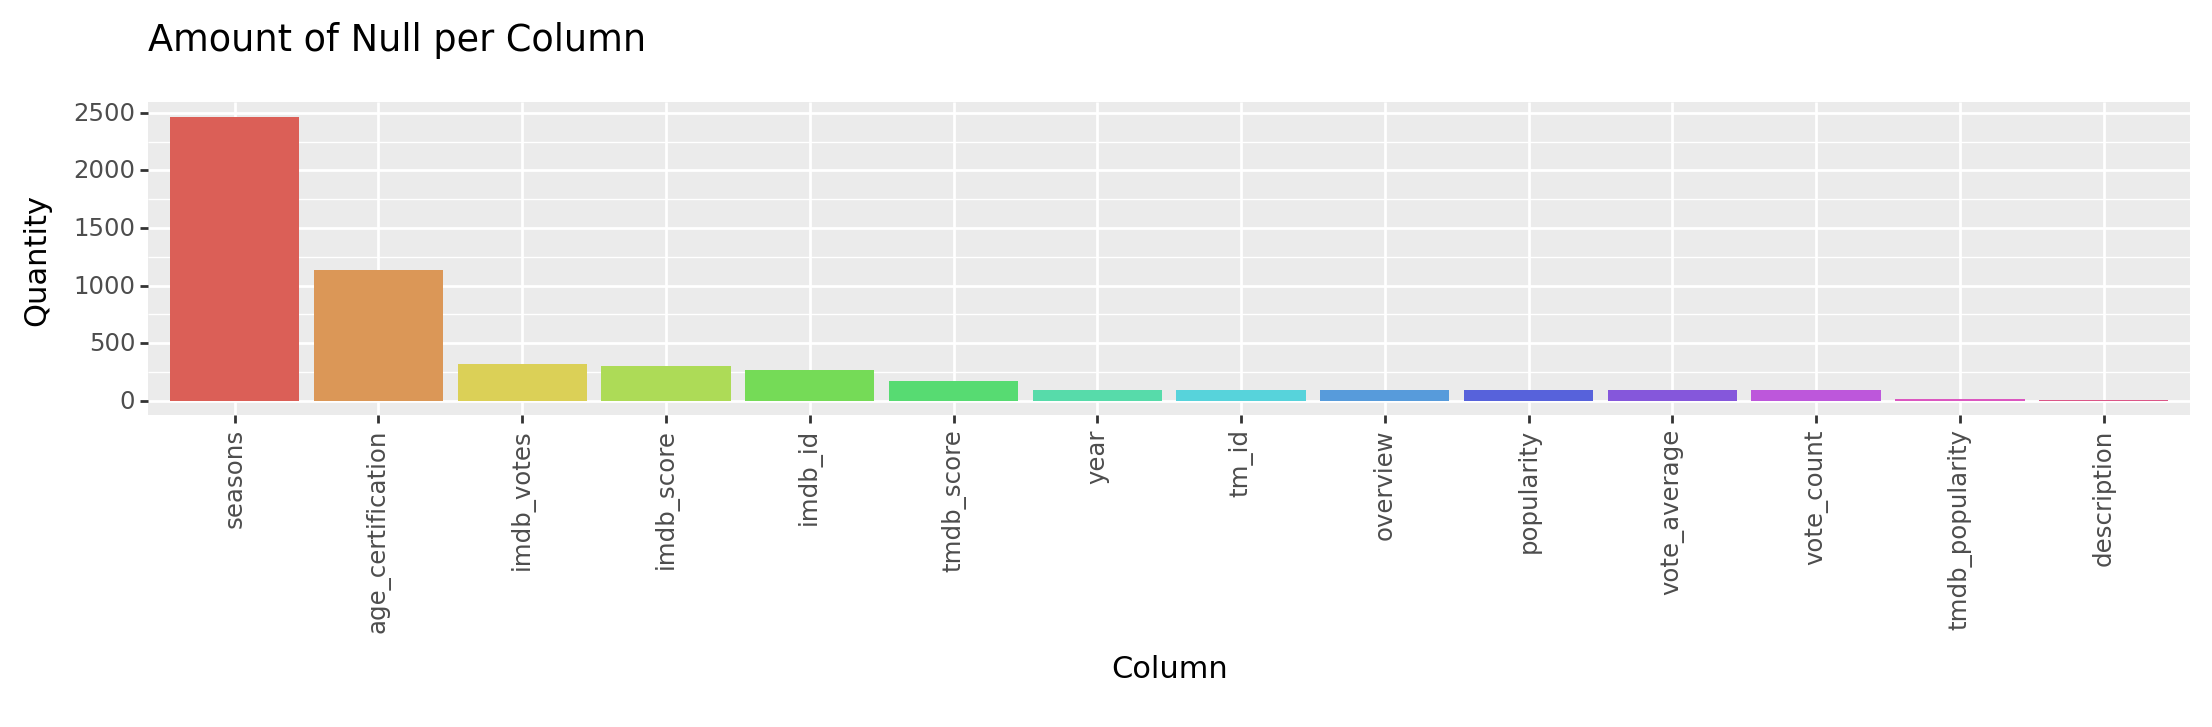

<Figure Size: (1106 x 363)>

In [3]:
# Amount of null 
temp = (
        dtm.isna().sum()[dtm.isna().sum() > 0]
        .sort_values(ascending=False)
        .reset_index(name='qtd')
        ).rename(columns={'index': 'col'})

temp['col'] = pd.Categorical(values=temp['col'], categories=temp['col'])

# Plot
(
    ggplot(temp, aes(x='col', y='qtd'))
    + geom_col(aes(fill='col'))
    + theme(figure_size=(15.80*0.7, 5.20*0.7), 
            axis_text_x=element_text(rotation=90))
    + labs(title='Amount of Null per Column',
           x = 'Column', 
           y = 'Quantity')
    + scale_fill_discrete(guide=False)
)


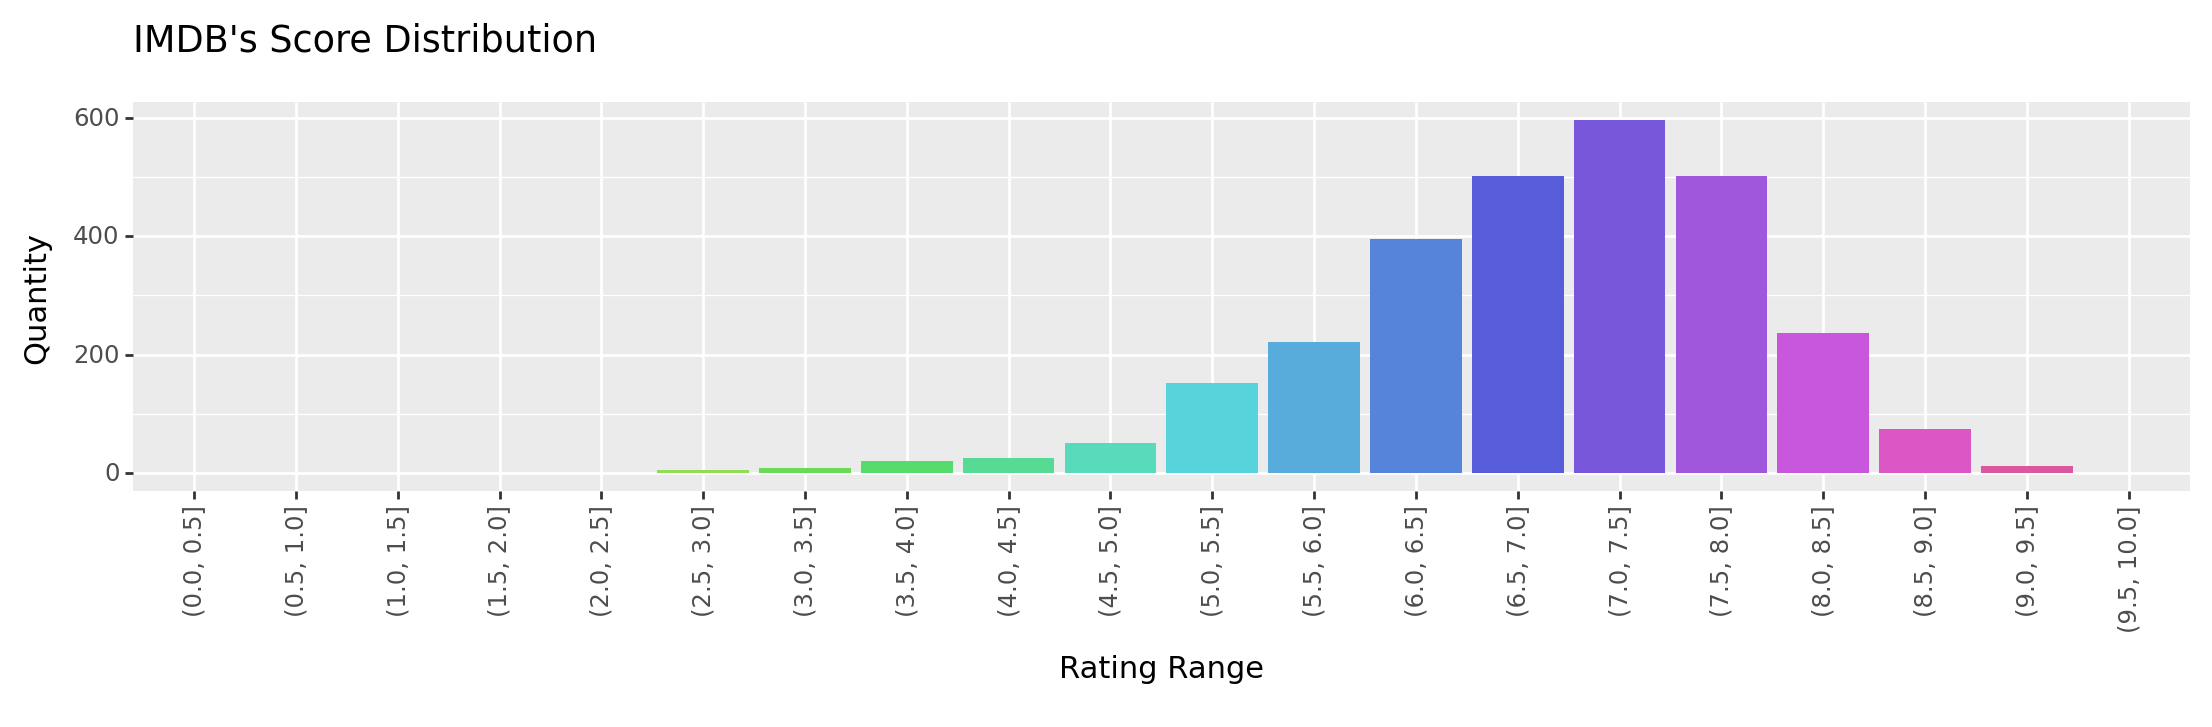

<Figure Size: (1106 x 363)>

In [4]:
temp = pd.cut(dtm['imdb_score'], bins=np.arange(0, 10.1, 0.5)).value_counts().reset_index()

(
    ggplot(temp)
    + geom_col(aes(x='imdb_score', y='count', fill='imdb_score'))
    + theme(figure_size=(15.80*0.7, 5.20*0.7), 
            axis_text_x=element_text(rotation=90))
    + labs(title="IMDB's Score Distribution",
           x = 'Rating Range', 
           y = 'Quantity')
    + scale_fill_discrete(guide=False)
)

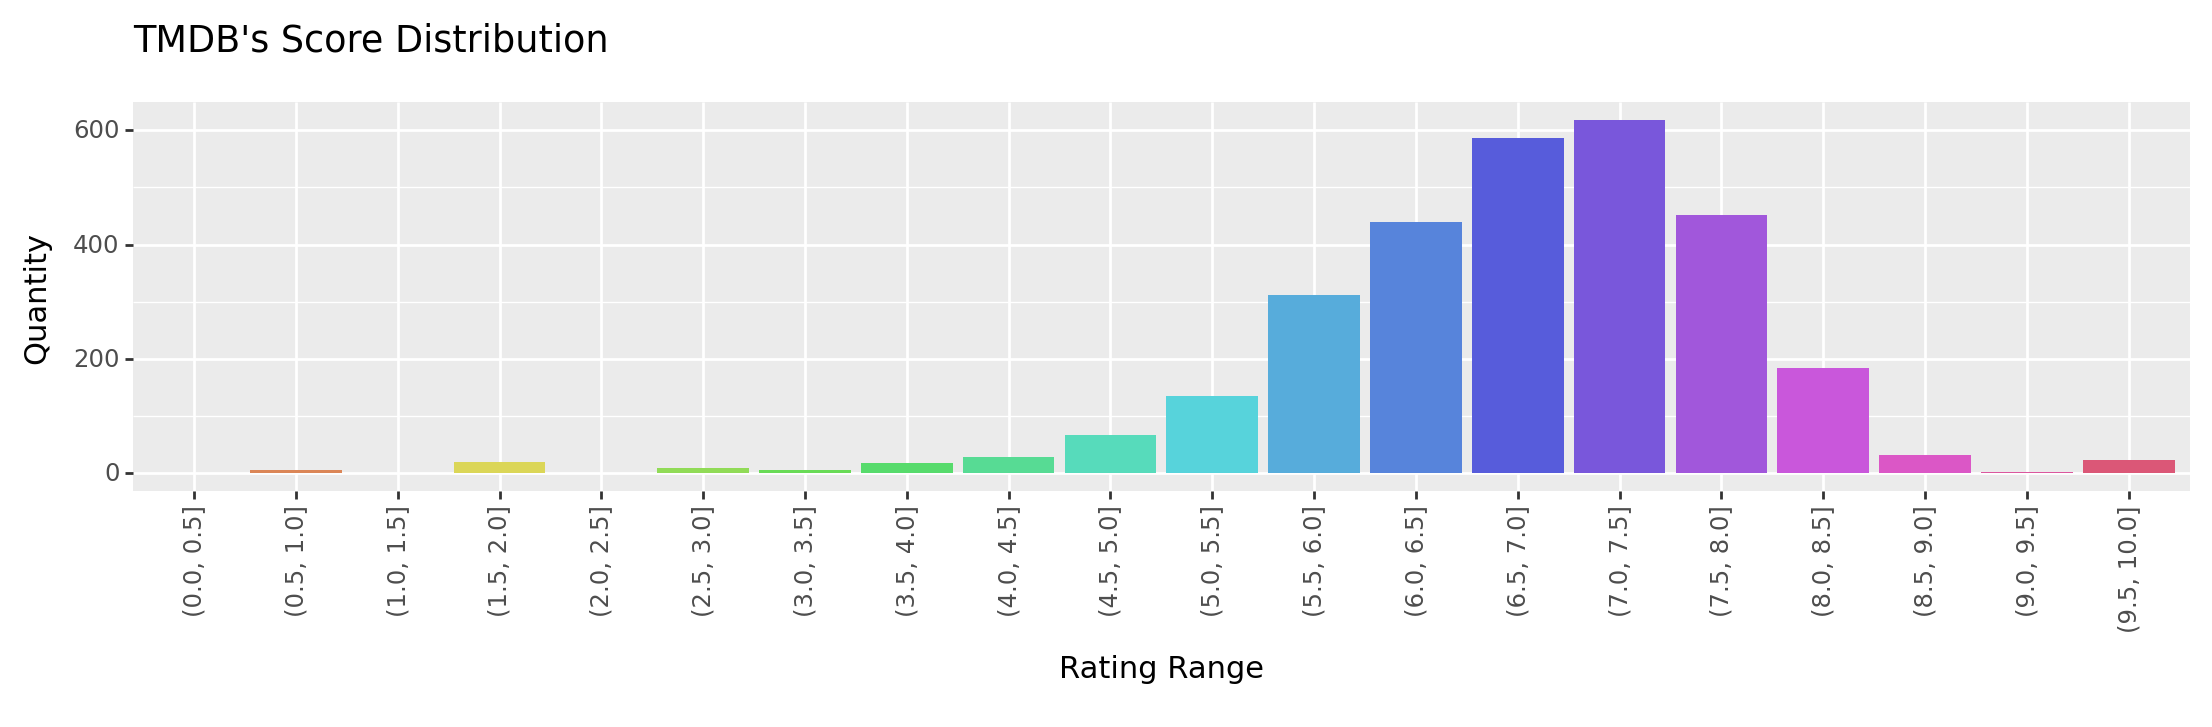

<Figure Size: (1106 x 363)>

In [5]:
temp = pd.cut(dtm['tmdb_score'], bins=np.arange(0, 10.1, 0.5)).value_counts().reset_index()

(
    ggplot(temp)
    + geom_col(aes(x='tmdb_score', y='count', fill='tmdb_score'))
    + theme(figure_size=(15.80*0.7, 5.20*0.7), 
            axis_text_x=element_text(rotation=90))
    + labs(title="TMDB's Score Distribution",
           x = 'Rating Range', 
           y = 'Quantity')
    + scale_fill_discrete(guide=False)
)

### IMDB weighted rating

IMDB's weighted rating formula is known as the IMDB Rating Formula or the IMDB Weighted Average. It is used to calculate the weighted rating of a movie based on its average rating and the number of votes it has received. The formula is as follows:

$$\text{Weighted Rating (WR)} = (v / (v + m)) * R + (m / (v + m)) * C$$

Where:

WR is the weighted rating  
R is the average rating of the movie  
v is the number of votes received by the movie  
m is the minimum number of votes required for the movie to be considered  
C is the mean rating across the entire dataset  

The purpose of the formula is to give more weight to movies with a higher number of votes, making the ratings more reliable and representative of the general audience opinion. It balances the average rating of a movie with the number of votes it has received.

The values of m and C may vary depending on the specific implementation or dataset used. IMDB does not disclose the exact values they use for m and C in their weighted rating formula.

In [18]:
v = 'vote_count'
m = 'vote_count.quantile(0.5)'
R = 'vote_average'
C = 'vote_average.mean()'

dtm.eval(f'weight_score_tmdb = ({v}/({v}+{m}) * {R}) + ({m}/({m}+{v}) * {C})', inplace=True)

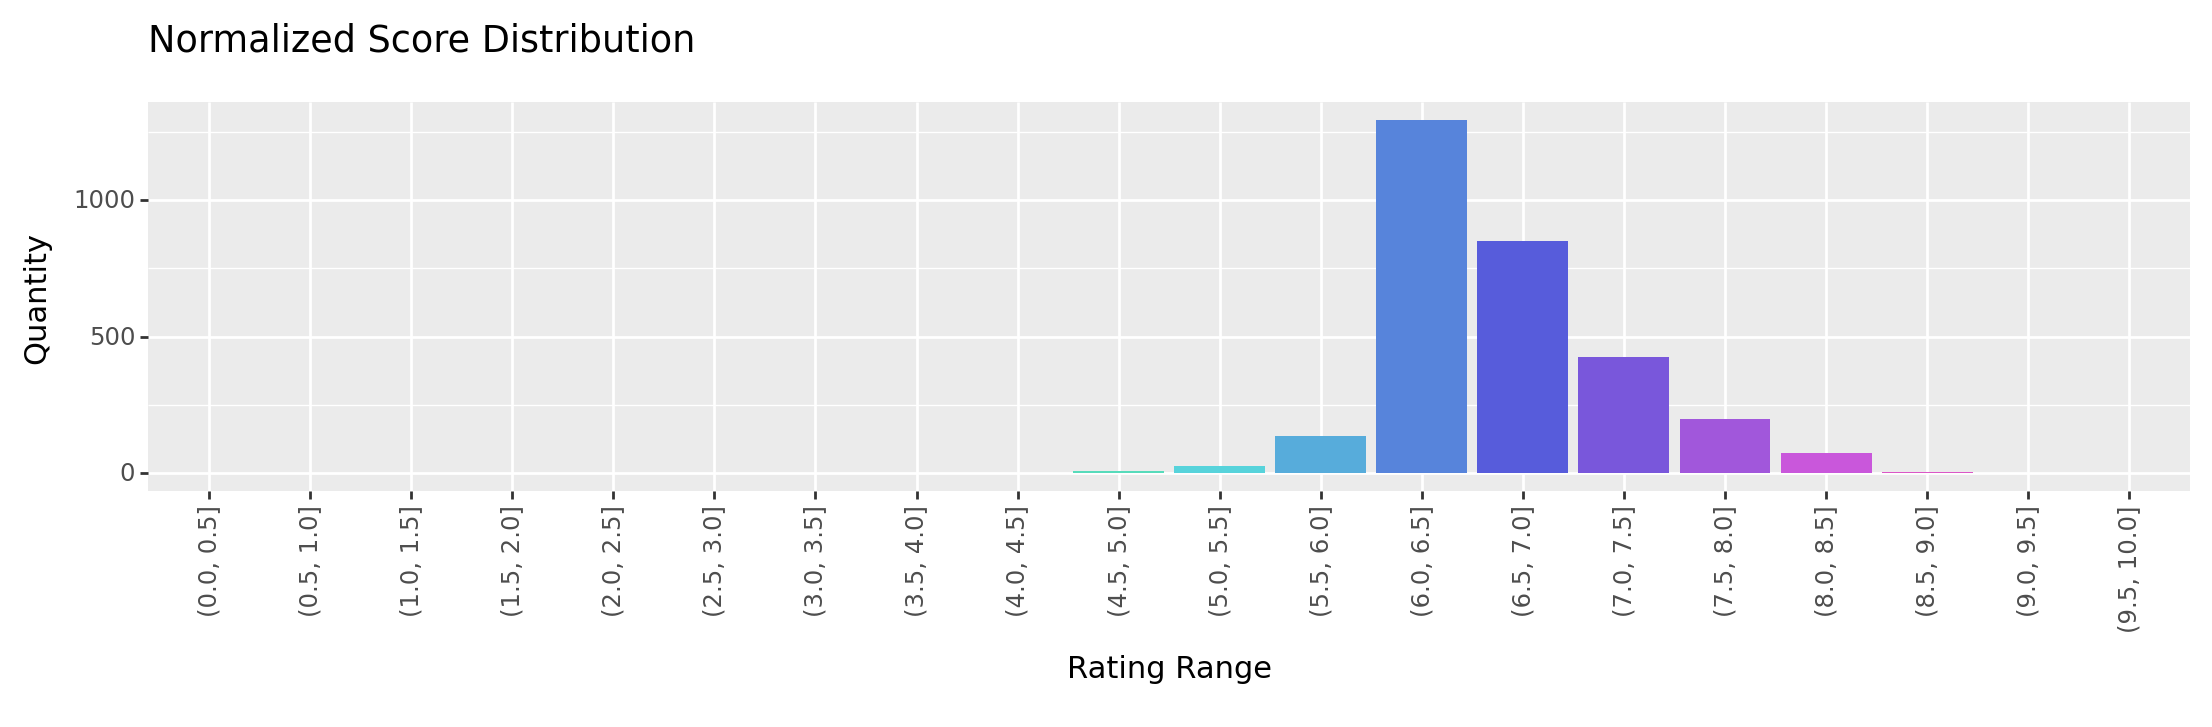

<Figure Size: (1106 x 363)>

In [19]:
temp = pd.cut(dtm['weight_score_tmdb'], bins=np.arange(0, 10.1, 0.5)).value_counts().reset_index()

(
    ggplot(temp)
    + geom_col(aes(x='weight_score_tmdb', y='count', fill='weight_score_tmdb'))
    + theme(figure_size=(15.80*0.7, 5.20*0.7), 
            axis_text_x=element_text(rotation=90))
    + labs(title="Normalized Score Distribution",
           x = 'Rating Range', 
           y = 'Quantity')
    + scale_fill_discrete(guide=False)
)

In [16]:
v = 'imdb_votes'
m = 'imdb_votes.quantile(0.5)'
R = 'imdb_score'
C = 'imdb_score.mean()'

dtm.eval(f'weight_score_imdb = ({v}/({v}+{m}) * {R}) + ({m}/({m}+{v}) * {C})', inplace=True)

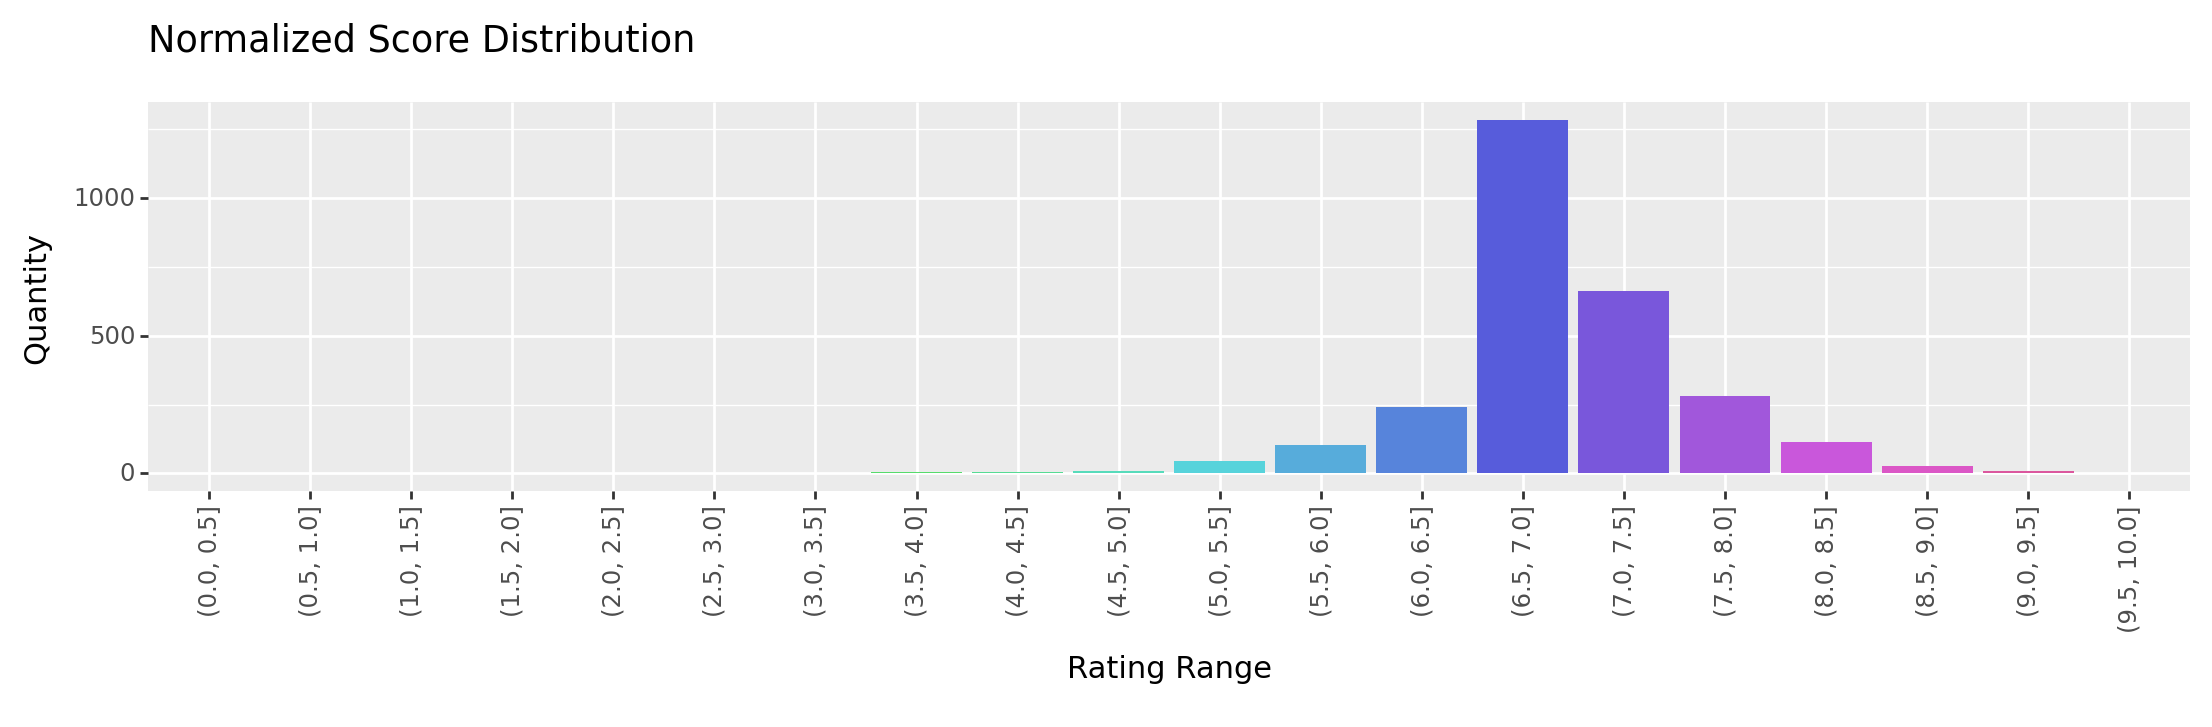

<Figure Size: (1106 x 363)>

In [17]:
temp = pd.cut(dtm['weight_score_imdb'], bins=np.arange(0, 10.1, 0.5)).value_counts().reset_index()

(
    ggplot(temp)
    + geom_col(aes(x='weight_score_imdb', y='count', fill='weight_score_imdb'))
    + theme(figure_size=(15.80*0.7, 5.20*0.7), 
            axis_text_x=element_text(rotation=90))
    + labs(title="Normalized Score Distribution",
           x = 'Rating Range', 
           y = 'Quantity')
    + scale_fill_discrete(guide=False)
)

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ydensity : Removed 321 rows containing non-finite values.
C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\plotnine\stats\stat_density.py:164: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\plotnine\stats\stat_density.py:169: PlotnineWarning: Groups with fewer than 2 data points have been removed.


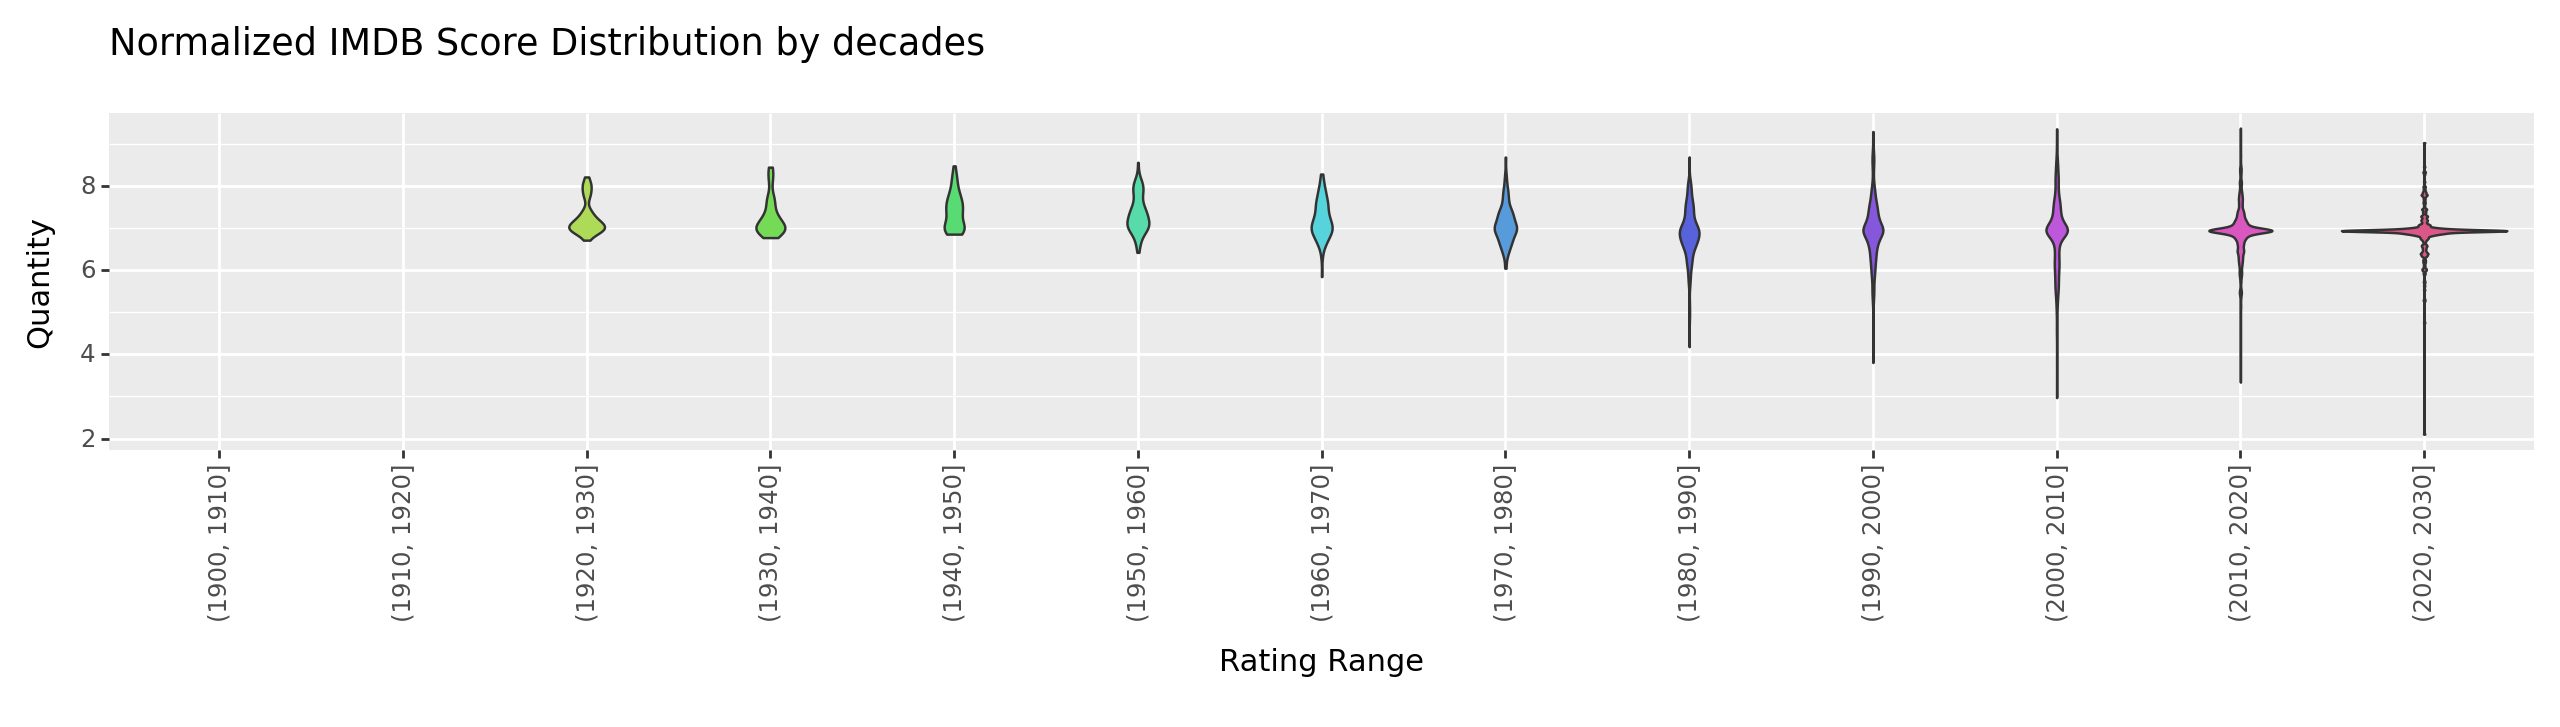

<Figure Size: (1280 x 363)>

In [62]:
temp = dtm

temp['decades'] = pd.cut(dtm['release_year'], bins=np.arange(1890, 2040, 10))

(
    ggplot(temp)
    + geom_violin(aes(x='decades', y='weight_score_imdb', fill='decades'))
    + theme(figure_size=(12.80, 5.20*0.7), 
            axis_text_x=element_text(rotation=90))
    + labs(title="Normalized IMDB Score Distribution by decades",
           x = 'Rating Range', 
           y = 'Quantity')
    + scale_fill_discrete(guide=False)
)


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ydensity : Removed 94 rows containing non-finite values.


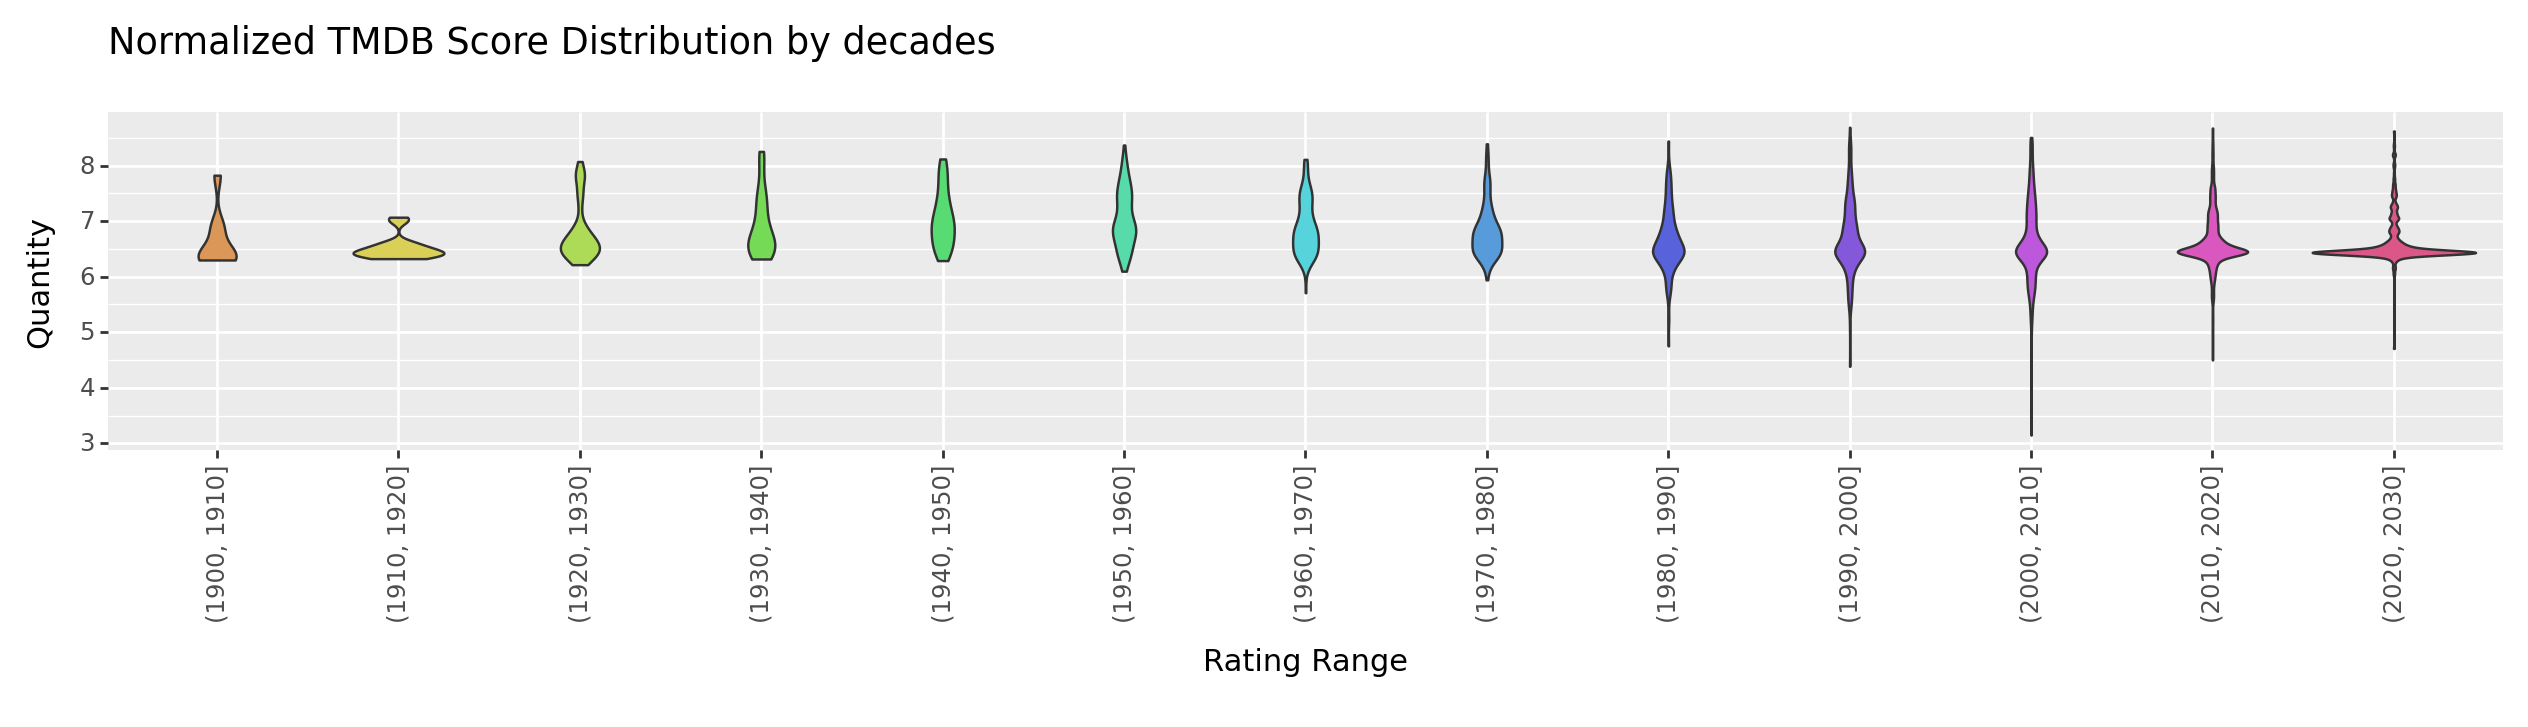

<Figure Size: (1264 x 363)>

In [63]:
temp = dtm

temp['decades'] = pd.cut(dtm['release_year'], bins=np.arange(1890, 2040, 10))

(
    ggplot(temp)
    + geom_violin(aes(x='decades', y='weight_score_tmdb', fill='decades'))
    + theme(figure_size=(15.80*0.8, 5.20*0.7), 
            axis_text_x=element_text(rotation=90))
    + labs(title="Normalized TMDB Score Distribution by decades",
           x = 'Rating Range', 
           y = 'Quantity')
    + scale_fill_discrete(guide=False)
)
